### First Machine Learning model
* Split test and train data
* Get some insights
* Train the model

#### Importing libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

#### Load data

In [4]:
avc = pd.read_parquet("../data/processed/new-avc.parquert")

#### Creating column year to stratify the dataset

In [6]:
avc["year"] = avc.date.dt.year

#### Split dataset in train and test

In [7]:
strat_train_set, strat_test_set = train_test_split(
    avc, test_size=0.2, stratify=avc["year"], random_state=42
)

In [8]:
# Look with the proportion is the same for all the years as expected
strat_test_set["year"].value_counts() / len(strat_test_set)

2016    0.168565
2013    0.166287
2014    0.166287
2015    0.166287
2018    0.166287
2017    0.166287
Name: year, dtype: float64

#### Stratfied vs random sampling

In [9]:
def income_cat_proportions(data):
    return data["year"].value_counts() / len(data)

train_set, test_set = train_test_split(avc, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(avc),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Year"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Year,,,,,
2013,16.66,16.63,17.77,-0.18,6.65
2014,16.66,16.63,15.72,-0.18,-5.65
2015,16.66,16.63,15.95,-0.18,-4.28
2016,16.70,16.86,14.81,0.91,-11.36
2017,16.66,16.63,18.91,-0.18,13.49
2018,16.66,16.63,16.86,-0.18,1.19


#### Delete year column, not necessary anymore

In [10]:
strat_test_set = strat_test_set.drop(columns="year")
strat_train_set = strat_train_set.drop(columns="year")

#### Exploratory data analysis

In [11]:
avc = strat_train_set.copy()

#### Looking for correlations

In [12]:
corr_matrix = avc.corr()

/tmp/ipykernel_2692/2997149164.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = avc.corr()


In [13]:
corr_matrix["respiratory"].sort_values(ascending=False)

respiratory                    1.000000
avc                            0.048194
so2_ugm3                       0.029319
o3_ppb                        -0.009726
focos_queimada                -0.009951
temperatura_c                 -0.028572
co_ppb                        -0.047439
precipitacao_mmdia            -0.064309
pm25_ugm3                     -0.091198
umidade_relativa_percentual   -0.171462
Name: respiratory, dtype: float64

In [14]:
corr_matrix["avc"].sort_values(ascending=False)

avc                            1.000000
respiratory                    0.048194
o3_ppb                         0.000767
so2_ugm3                      -0.000525
temperatura_c                 -0.004410
pm25_ugm3                     -0.007494
co_ppb                        -0.008829
focos_queimada                -0.014417
umidade_relativa_percentual   -0.027136
precipitacao_mmdia            -0.034166
Name: avc, dtype: float64

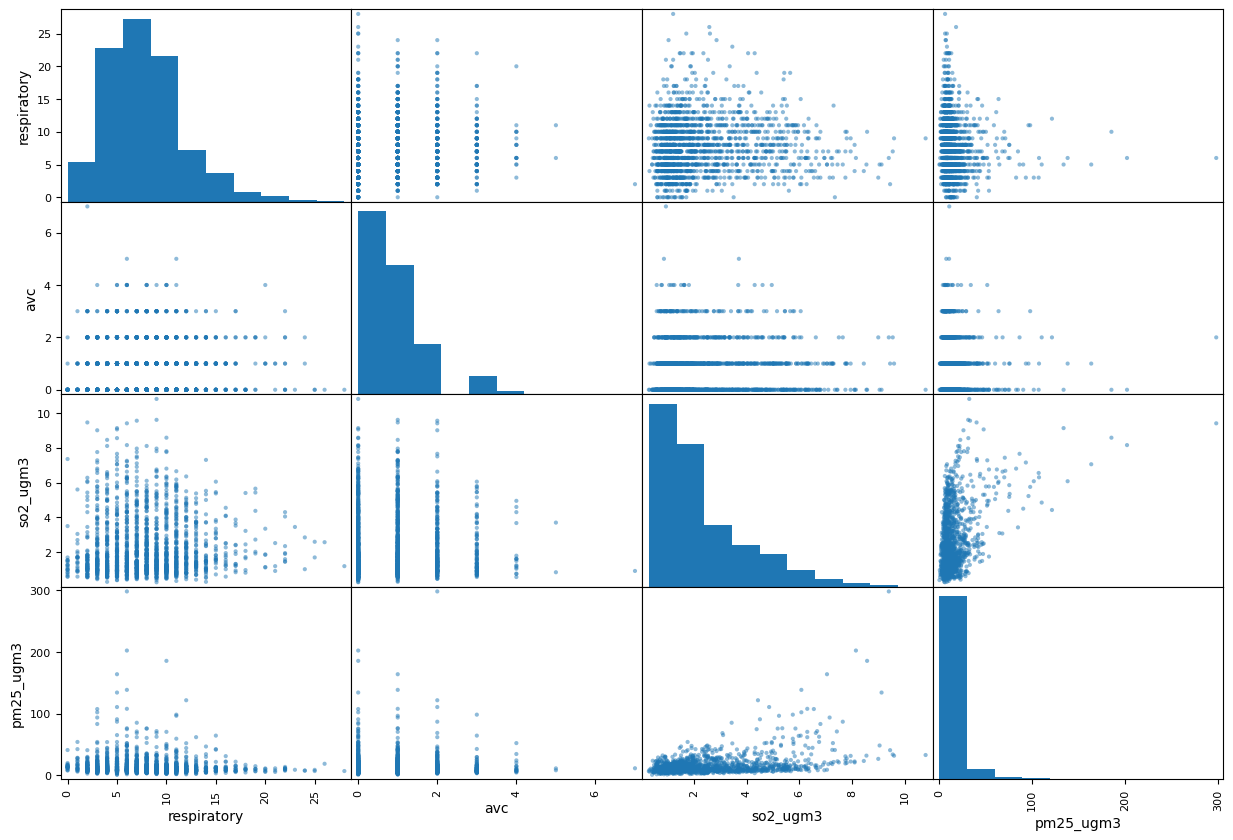

In [17]:
# Generate correlation plot with pandas
from pandas.plotting import scatter_matrix, hist_frame

columns = ["respiratory", "avc", "so2_ugm3", \
           "pm25_ugm3"]

scatter_matrix(avc[columns], figsize=(15, 10))
plt.show()

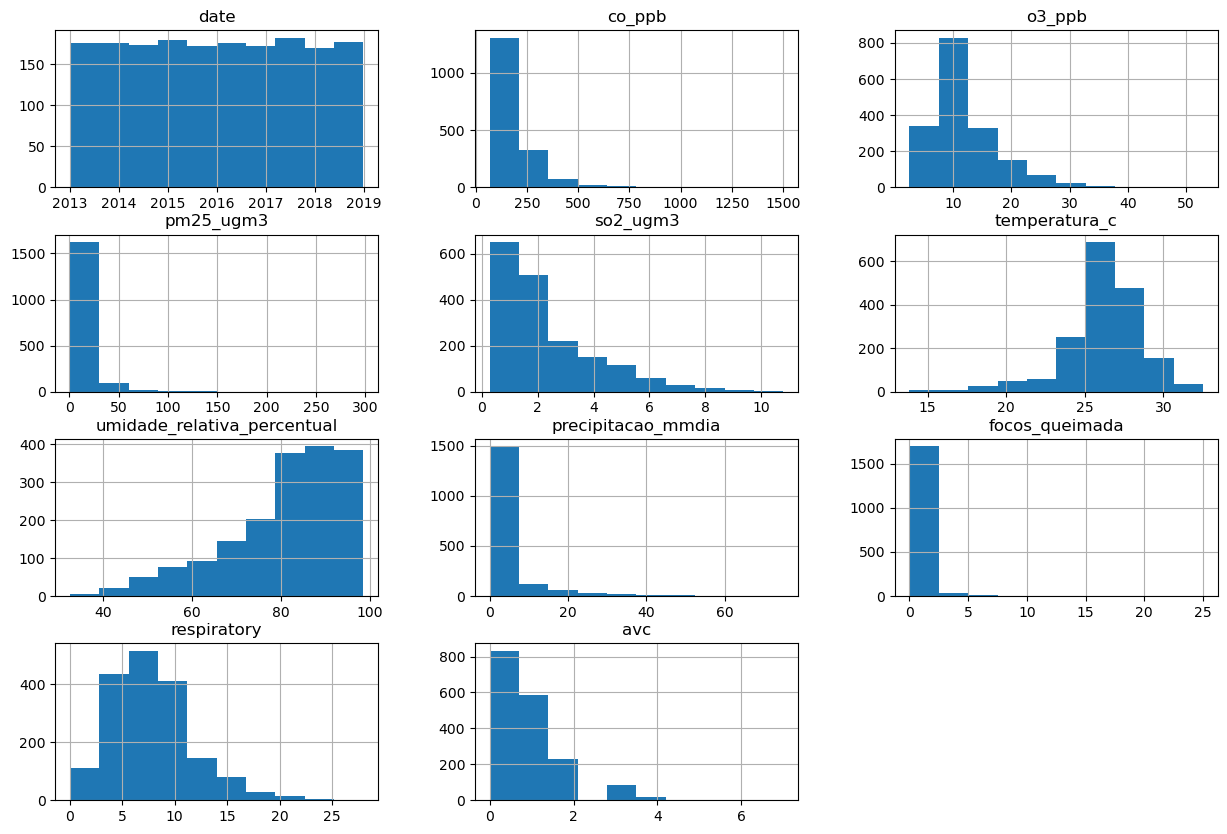

In [18]:
hist_frame(avc, figsize=(15,10))
plt.show()

In [19]:
avc = strat_train_set.drop(columns=["respiratory", "avc", "date"])
avc_labels = strat_train_set.respiratory.copy()

#### Making the pipeline

In [22]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer

avc.columns

pipe = Pipeline([
    # ("log", FunctionTransformer(np.log, feature_names_out="one-to-one")),
    ("standardize", StandardScaler())
])

preprocessing = ColumnTransformer([
    ("standardize", pipe, avc.columns.values)
])

In [23]:
avc_processed = preprocessing.fit_transform(avc)
avc_processed[:2]

array([[-0.39396257,  0.59413161, -0.44984978,  1.02518177, -0.32223744,
        -2.00975997, -0.41492787, -0.21325664],
       [-0.37580186, -0.29970428, -0.45396512, -0.2266124 , -0.04480733,
         0.64115705, -0.41492787, -0.21325664]])

In [24]:
avc_processed = pd.DataFrame(
    avc_processed, 
    columns=preprocessing.get_feature_names_out(), 
    index=avc.index
    )

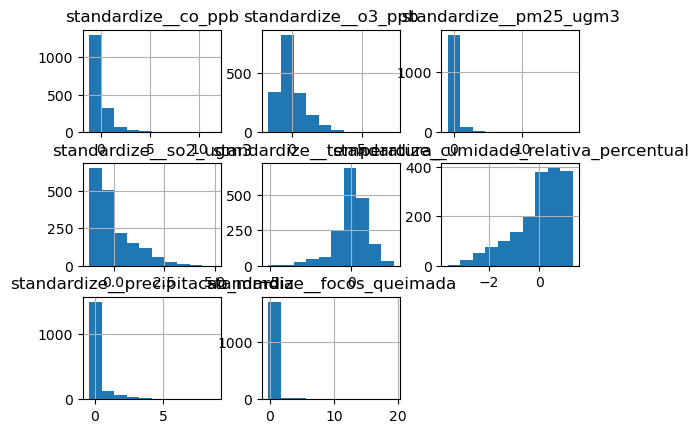

In [25]:
hist_frame(avc_processed)
plt.show()

#### Train and Evaluate on the Training Set

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Linear Regression
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(avc, avc_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardize',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  array(['co_ppb', 'o3_ppb', 'pm25_ugm3', 'so2_ugm3', 'temperatura_c',
       'umidade_relativa_percentual', 'precipitacao_mmdia',
       'focos_queimada'], dtype=object))])),
                ('linearregression', LinearRegression())])

In [27]:
avc_predict = lin_reg.predict(avc)
avc_predict[:3].round()

array([10.,  7.,  9.])

In [28]:
avc_labels[:3]

/tmp/ipykernel_2692/4090567344.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  avc_labels[:3]


942     7.0
831     5.0
1365    6.0
Name: respiratory, dtype: float64

In [29]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(avc_labels, avc_predict)
print(f"The error is: {lin_rmse.round(2)}")

The error is: 15.17


##### Decision Tree Regressor

In [30]:
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(avc, avc_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardize',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  array(['co_ppb', 'o3_ppb', 'pm25_ugm3', 'so2_ugm3', 'temperatura_c',
       'umidade_relativa_percentual', 'precipitacao_mmdia',
       'focos_queimada'], dtype=object))])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [31]:
avc_predict = tree_reg.predict(avc)
tree_rmse = mean_squared_error(
    avc_labels, 
    avc_predict, 
    squared=False
    )

print(f"The error is: {tree_rmse}, is this possible?")

The error is: 0.0, is this possible?


##### Making cross validation

In [32]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(
    tree_reg, 
    avc, 
    avc_labels, 
    scoring="neg_root_mean_squared_error",
    cv=10
    )

pd.Series(tree_rmses).describe()

count    10.000000
mean      5.235191
std       0.220469
min       4.928466
25%       5.074558
50%       5.236928
75%       5.423998
max       5.566225
dtype: float64

##### Random Forest Regressor

In [33]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, avc, avc_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

pd.Series(forest_rmses).describe()

count    10.000000
mean      3.779896
std       0.169013
min       3.542391
25%       3.658229
50%       3.759586
75%       3.933373
max       4.033178
dtype: float64